---
Modeling the relationship between urban tree canopy, land cover, and land surface temperature
---

# Introduction
This exercise first shows some exploratory tasks to model LST and tree canopy to explore Urban Heat Island. As [described here by NASA](https://earthobservatory.nasa.gov/global-maps/MOD_LSTD_M), "land surface temperature is how hot the 'surface' of the Earth would feel to the touch in a particular location". It also lays out an initial modeling approach that combines exploratory data analysis with KNN regresson and [decision tree models](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052) to better understand patterns the data and for prediction purposes in the R environment.  

We will use three primary datasets. The first are [land surface temperature (LST) data](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-level-2-provisional-surface?qt-science_center_objects=0#qt-science_center_objects) taken from the USGS EarthExplorer repository’s Analysis Ready Data series. These were processed to derive mean, minimum, and maximum LST in degrees Fahrenheit for each Census block group based on the 30 x 30 meter grid cells from the source Landsat images that fall within the boundary of the block group. 

We also calculated the percentage of each block group comprised by the [land cover designations](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) in the 2016 National Land Cover Database maintained by the U.S. Geological Survey (USGS). 

Finally, we collected tree canopy data for Washington, DC from [Open Data DC](https://opendata.dc.gov/datasets/DCGIS::urban-tree-canopy-2020/about). This exercise focuses on the machine learning modeling and not on data collection from satellite imagery or tree canopy data. Only curated data files are shared here without going to the details of data curation process.

Before we dive into the modeling component, let's explore the data a little. 

The first code chunk is where we will load all the packages and the Washington data that we will need. **Please note** that you may need to install some of the packages below before you can load them with the `library` function. It also pulls in Census block group boundaries directly from the city's open data portal.

In [1]:
#install.packages("caret", repos="http://cran.r-project.org")
#install.packages("FNN", repos="http://cran.r-project.org")
#install.packages("ggmap", repos="http://cran.r-project.org")
#install.packages("ISLR", repos="http://cran.r-project.org")
#install.packages("psych", repos="http://cran.r-project.org")
#install.packages("rpart", repos="http://cran.r-project.org")
#install.packages("rpart.plot", repos="http://cran.r-project.org")
#install.packages("rsample", repos="http://cran.r-project.org")
# install.packages("tidyverse", repos="http://cran.r-project.org")
#remove.packages("rlang")
#install.packages("rlang")
#install.packages("readr")

#install.packages("geojsonio")
#library(geojsonio)
#install.packages("DataExplorer")
#install.packages("corrplot")
#install.packages("randomForest")

library(corrplot)
library(ggplot2)
library(caret)
#library(FNN)
library(ggmap)
#library(ISLR)
#library(psych)
library(rpart)
library(rpart.plot)
library(rsample)
library(sf)
library(tidyverse)
library(DataExplorer)
library(corrplot)
library(ModelMetrics)
#library(tigris)
#library(readr)
library(randomForest)

corrplot 0.92 loaded

Loading required package: lattice

ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.
Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ModelMetric

In [2]:
dc.data <- read.csv("data/WashingtonDC.csv")
dc.bgs <- st_read("data/WashingtondcBG2.shp")
head(dc.data)

Reading layer `WashingtondcBG2' from data source 
  `/home/jovyan/R/UHI/data/WashingtondcBG2.shp' using driver `ESRI Shapefile'
Simple feature collection with 450 features and 12 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -77.11976 ymin: 38.79164 xmax: -76.90939 ymax: 38.99555
Geodetic CRS:  NAD83


,X,GEOID,ALAND10,AWATER10,TotPop,ai,area_mn,cohesion,division,ed,⋯,BareRock,Dec_Forest,Evgn_Forest,Mix_Forest,Scrub,Grassland,Pasture,Crops,Wood_wetland,Herb_wetland
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.1001e+11,813493,0,1508,97.68256,0.06953893,99.84115,0.6228505,0,⋯,0.05611672,17.1156004,0.1122334,2.637486,0.2805836,NA,0.3367003,0.3367003,0.3928171,0.2805836
2,2,1.1001e+11,199344,0,1376,96.41470,0.02816269,98.98726,0.8690387,0,⋯,1.44927536,0.2070393,NA,NA,NA,NA,NA,2.8985507,NA,NA
3,3,1.1001e+11,194349,0,1108,94.84385,0.01960612,98.21281,0.9702690,0,⋯,NA,NA,NA,1.488095,NA,NA,NA,NA,NA,NA
4,4,1.1001e+11,661619,500891,896,98.01035,0.04936734,99.52491,0.5545738,0,⋯,1.91297824,3.1507877,NA,3.263316,0.1125281,0.03750938,NA,1.1252813,7.5018755,1.1627907
5,5,1.1001e+11,542544,0,3922,97.43979,0.04151734,99.08262,0.7656407,0,⋯,2.38948626,11.1111111,NA,1.433692,NA,0.83632019,NA,NA,NA,NA
6,6,1.1001e+11,189094,0,1242,95.95668,0.02470171,98.51543,0.9609062,0,⋯,0.16025641,8.0128205,0.1602564,NA,NA,NA,NA,NA,NA,NA


The **sf** object called `dc.bgs` contains many attributes, as outlined in the [metadata here](https://opendata.dc.gov/datasets/DCGIS::census-block-groups-2010/about), but we mainly want these boundaries for visualizing heat exposure, land cover, and tree canopy coverage in the city. WashingtonDC.csv file contains data on land surface temperature, land cover, and different landscape metrics for tree canopy at the census block group level.

Let's do some quick exploratory data analysis before proceeding. 

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


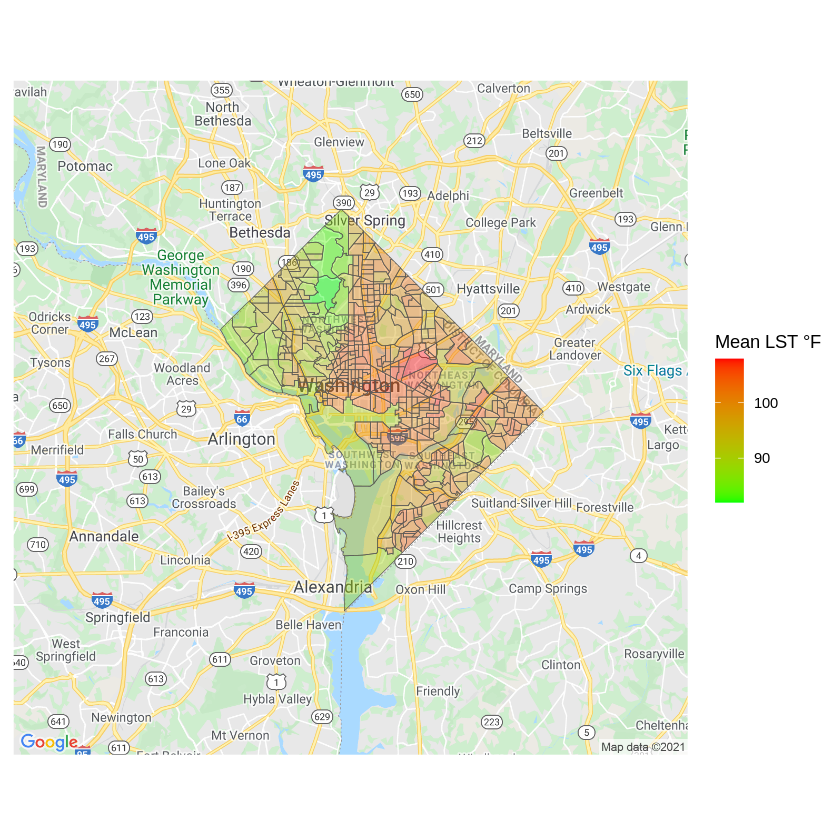

In [3]:
# Read the DC basemap so we do not have to retrieve it from 
# the web (i.e., use a Google API key each time)

load(file = "data/dc_basemap.RData")

dc.bgs.wgs84 <- st_transform(dc.bgs, 4326)
dc.bgs.wgs84 <- dc.bgs.wgs84 %>% mutate(GEOID.dbl = as.numeric(GEOID10))

dc.bg.data.wgs84 <- full_join(dc.bgs.wgs84, dc.data, by = c("GEOID.dbl" = "GEOID"))
dc.bg.data.wgs84 <- st_transform(dc.bg.data.wgs84, 4326)

# Recode NA to zero for NLCD variables
dc.bg.data.wgs84 <- dc.bg.data.wgs84 %>% replace(is.na(.), 0)

# Add categorical populations variable based on terciles
dc.bg.data.wgs84 <- dc.bg.data.wgs84 %>% 
    filter(!is.na(TotPop)) %>%
    mutate(Pop_Tercile = case_when(
      TotPop < 1125 ~ "Low",
      TotPop < 1700 & TotPop >= 1125 ~ "Middle",
      TotPop >= 1700 ~ "High"))

mean.lst.map <- ggmap(dc_basemap) +
  geom_sf(data = dc.bg.data.wgs84, aes(fill = MeanF), alpha = 0.4, inherit.aes = FALSE) +
    scale_fill_gradient(low = "green", high = "red") +
    theme_classic() +
    theme(axis.line = element_blank(), axis.text = element_blank(),
        axis.ticks = element_blank(), axis.title = element_blank()) + 
    labs(fill = "Mean LST °F")

mean.lst.map

The above code chunk created map for mean land surface temperature at census block group level. Now we will create maps for high intensity and medium intensity developments to visually compare them with temperature map.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


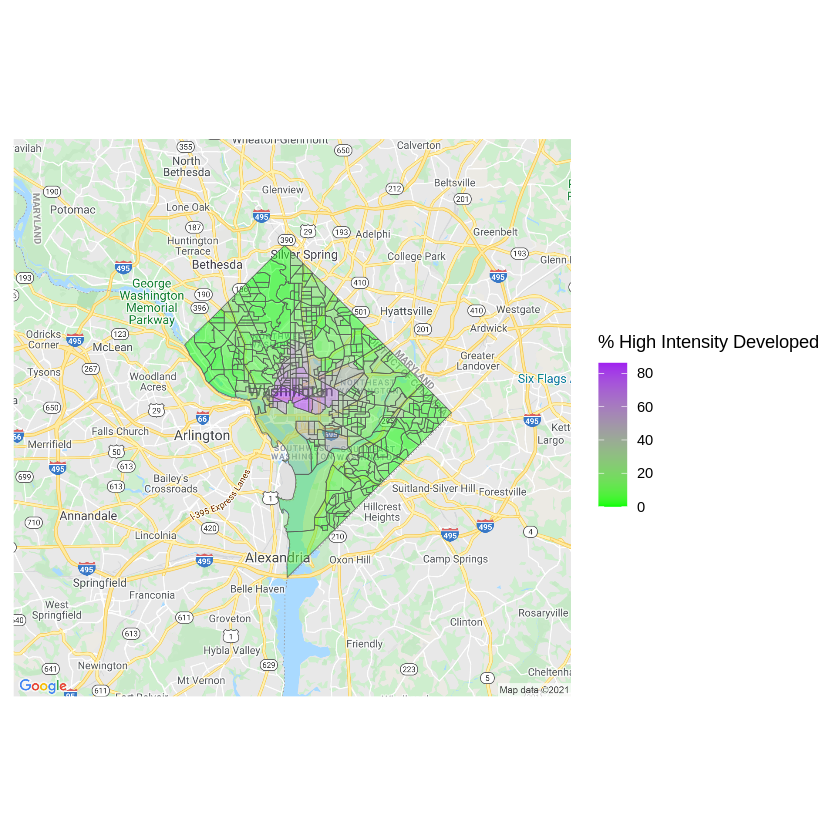

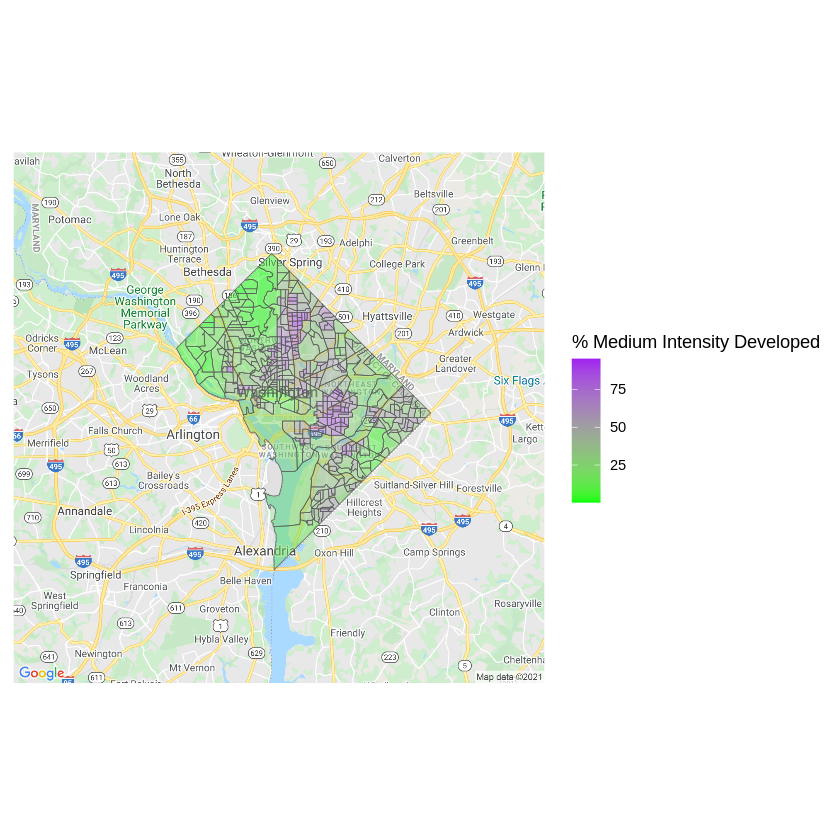

In [4]:
dev.high.map <- ggmap(dc_basemap) +
  geom_sf(data = dc.bg.data.wgs84, aes(fill = Dev_HighIntensity), alpha = 0.5, inherit.aes = FALSE) +
    scale_fill_gradient(low = "green", high = "purple") +
    theme_classic() +
    theme(axis.line = element_blank(), axis.text = element_blank(),
        axis.ticks = element_blank(), axis.title = element_blank()) + 
    labs(fill = "% High Intensity Developed")

dev.med.map <- ggmap(dc_basemap) +
  geom_sf(data = dc.bg.data.wgs84, aes(fill = Dev_MedIntensity), alpha = 0.5, inherit.aes = FALSE) +
    scale_fill_gradient(low = "green", high = "purple") +
    theme_classic() +
    theme(axis.line = element_blank(), axis.text = element_blank(),
        axis.ticks = element_blank(), axis.title = element_blank()) + 
    labs(fill = "% Medium Intensity Developed")

dev.high.map
dev.med.map

In [5]:
#Check out the variables available in the provided data.
colnames(dc.bg.data.wgs84)

[1] "STATEFP10"         "COUNTYFP10"        "TRACTCE10"        
 [4] "BLKGRPCE10"        "GEOID10"           "NAMELSAD10"       
 [7] "MTFCC10"           "FUNCSTAT10"        "ALAND10.x"        
[10] "AWATER10.x"        "INTPTLAT10"        "INTPTLON10"       
[13] "GEOID.dbl"         "X"                 "ALAND10.y"        
[16] "AWATER10.y"        "TotPop"            "ai"               
[19] "area_mn"           "cohesion"          "division"         
[22] "ed"                "frac_mn"           "lpi"              
[25] "lsi"               "mesh"              "pafrac"           
[28] "para_mn"           "pd"                "pladj"            
[31] "shape_mn"          "split"             "ta"               
[34] "COUNT"             "AREA"              "Name"             
[37] "Date"              "Year"              "MeanF"            
[40] "StdDevF"           "MinF"              "MaxF"             
[43] "Water"             "P_Ice"             "Dev_OpenSpace"    
[46] "Dev_LowIntensity"  "Dev_MedIntensity"  "Dev_HighIntensity"
[49] "BareRock"          "Dec_Forest"        "Evgn_Forest"      
[52] "Mix_Forest"        "Scrub"             "Grassland"        
[55] "Pasture"           "Crops"             "Wood_wetland"     
[58] "Herb_wetland"      "geometry"          "Pop_Tercile"

,MeanF,StdDevF,MinF,MaxF
MeanF,1.00,-0.60,0.88,0.50
StdDevF,-0.60,1.00,-0.83,0.24
MinF,0.88,-0.83,1.00,0.25
MaxF,0.50,0.24,0.25,1.00


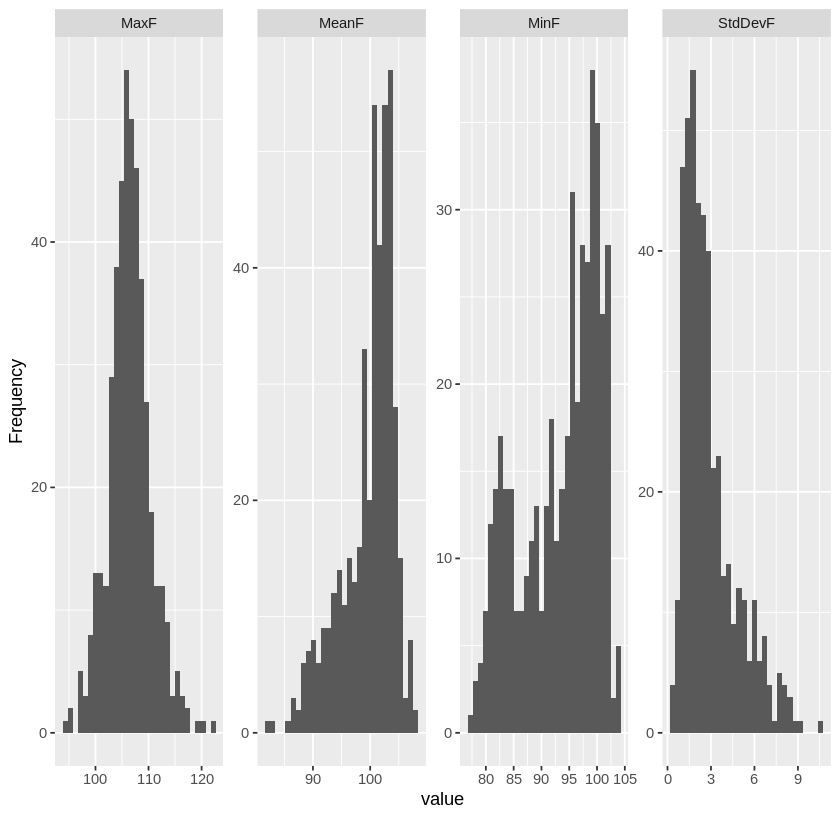

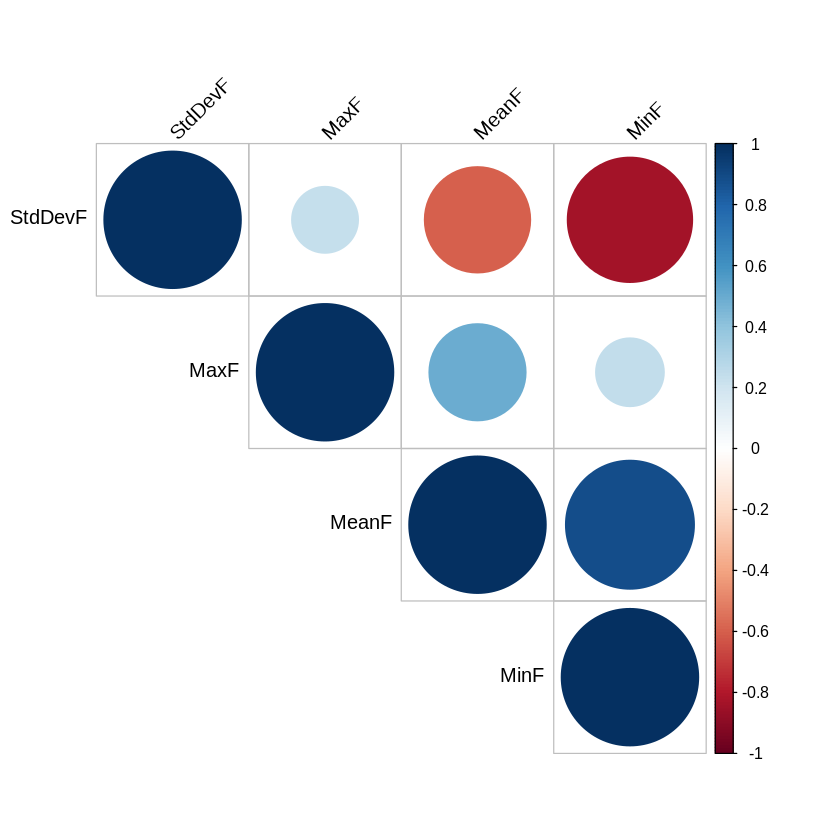

In [6]:
# For all continuous LST variables in the dataset...

plot_histogram(dc.bg.data.wgs84[ , 39:42])
#ggsave("lst_vars_hist.png", width = 18, height = 8)
res <- cor(st_drop_geometry(dc.bg.data.wgs84[ , c(39:42)]), use = "pairwise.complete.obs")
round(res, 2)
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

In [7]:
summary((dc.bg.data.wgs84[18:29]))

       ai           area_mn            cohesion        division     
 Min.   :91.88   Min.   :0.005532   Min.   :94.88   Min.   :0.2138  
 1st Qu.:94.21   1st Qu.:0.011725   1st Qu.:96.82   1st Qu.:0.9077  
 Median :95.39   Median :0.018846   Median :97.99   Median :0.9607  
 Mean   :95.46   Mean   :0.030497   Mean   :97.86   Mean   :0.9017  
 3rd Qu.:96.64   3rd Qu.:0.033230   3rd Qu.:99.06   3rd Qu.:0.9795  
 Max.   :99.33   Max.   :0.308860   Max.   :99.97   Max.   :0.9956  
       ed       frac_mn           lpi              lsi         
 Min.   :0   Min.   :1.106   Min.   : 2.126   Min.   :  6.608  
 1st Qu.:0   1st Qu.:1.146   1st Qu.: 7.534   1st Qu.: 16.239  
 Median :0   Median :1.162   Median :13.406   Median : 20.631  
 Mean   :0   Mean   :1.166   Mean   :20.670   Mean   : 22.270  
 3rd Qu.:0   3rd Qu.:1.181   3rd Qu.:25.594   3rd Qu.: 25.940  
 Max.   :0   Max.   :1.291   Max.   :88.654   Max.   :103.034  
      mesh               pafrac         para_mn             pd       

For all continuous landscape variables in the dataset...

   MTFCC10           FUNCSTAT10          ALAND10.x         AWATER10.x     
 Length:450         Length:450         Min.   :  31158   Min.   :      0  
 Class :character   Class :character   1st Qu.: 126138   1st Qu.:      0  
 Mode  :character   Mode  :character   Median : 213000   Median :      0  
                                       Mean   : 351366   Mean   :  41967  
                                       3rd Qu.: 366469   3rd Qu.:      0  
                                       Max.   :6583173   Max.   :5285078  
  INTPTLAT10         INTPTLON10          GEOID.dbl             X        
 Length:450         Length:450         Min.   :1.1e+11   Min.   :  1.0  
 Class :character   Class :character   1st Qu.:1.1e+11   1st Qu.:113.2  
 Mode  :character   Mode  :character   Median :1.1e+11   Median :225.5  
                                       Mean   :1.1e+11   Mean   :225.5  
                                       3rd Qu.:1.1e+11   3rd Qu.:337.8  
                                     

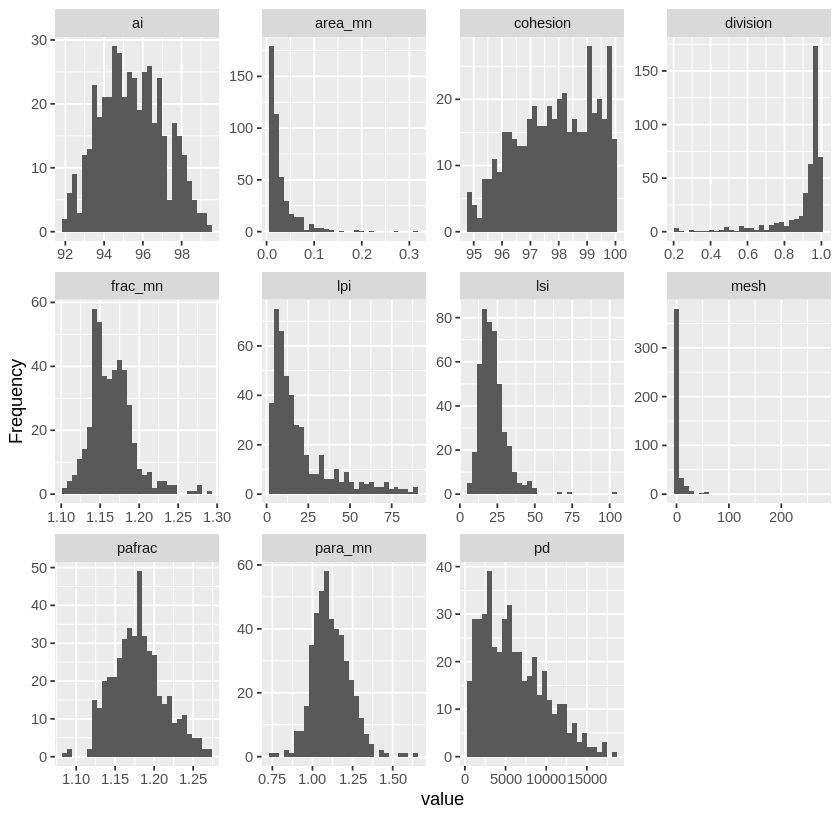

In [8]:
plot_histogram(dc.bg.data.wgs84[ , 18:29])
#ggsave("landscape_vars_hist.png", width = 18, height = 8)
summary((dc.bg.data.wgs84[ , 7:22]))

Following code chunks create plots showing the distribution of land surface temperature with high, medium, and low intensity development, and how population size and mean patch size of tree canopy are distributed at census block group level.

`geom_smooth()` using formula = 'y ~ x'


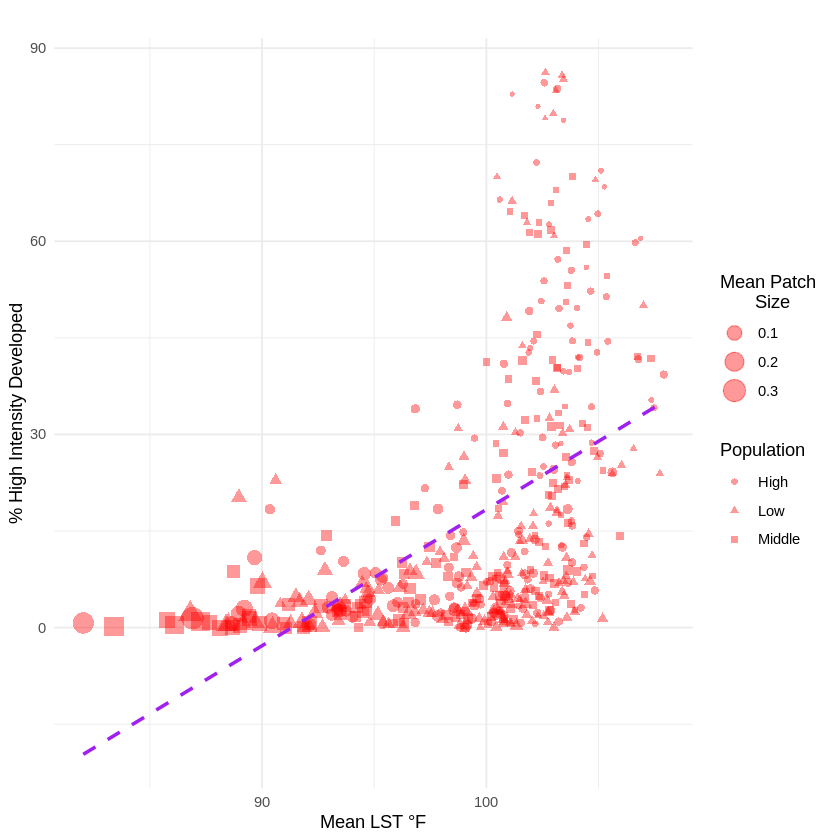

In [9]:
high.dev.lst.plot <- dc.bg.data.wgs84 %>%
  filter(!is.na(Dev_HighIntensity)) %>%
  ggplot(aes(x = MeanF, y = Dev_HighIntensity)) + 
  geom_point(aes(size = area_mn, shape = Pop_Tercile), color="red", alpha = 0.4) +
  geom_smooth(method=lm, se=FALSE, color = "purple", linetype="dashed") +
  theme_minimal() +
  labs(title = "", x = "Mean LST °F", y = "% High Intensity Developed", size = "Mean Patch 
       Size", shape = "Population") 

high.dev.lst.plot

`geom_smooth()` using formula = 'y ~ x'


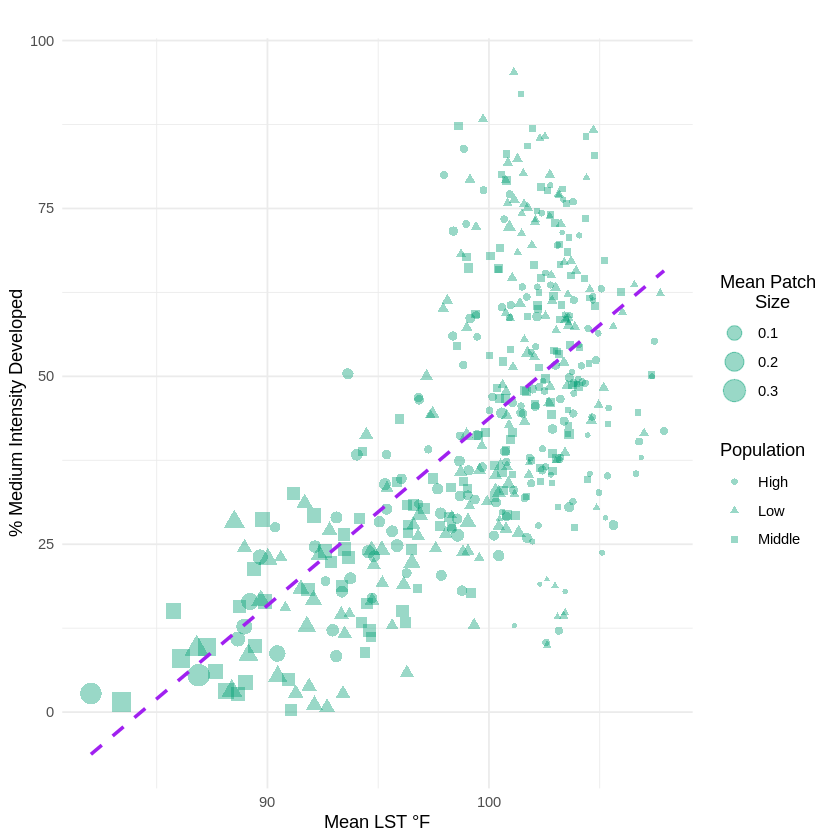

In [10]:
med.dev.lst.plot <- dc.bg.data.wgs84 %>%
  filter(!is.na(Dev_MedIntensity)) %>%
  ggplot(aes(x = MeanF, y = Dev_MedIntensity)) + 
  geom_point(aes(size = area_mn, shape = Pop_Tercile), color = "#009E73", alpha = 0.4) +
  geom_smooth(method=lm, se=FALSE, color = "purple", linetype="dashed") +
  theme_minimal() +
  labs(title = "", x = "Mean LST °F", y = "% Medium Intensity Developed", size = "Mean Patch 
       Size", shape = "Population") 

med.dev.lst.plot

`geom_smooth()` using formula = 'y ~ x'


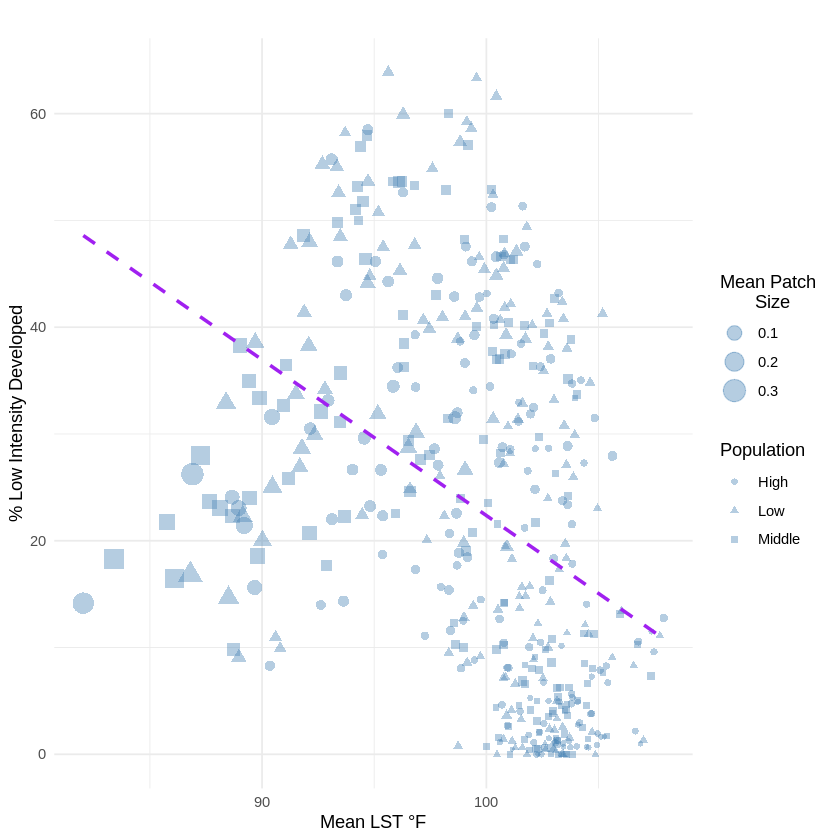

In [11]:
low.dev.lst.plot <- dc.bg.data.wgs84 %>%
  filter(!is.na(Dev_LowIntensity)) %>%
  ggplot(aes(x = MeanF, y = Dev_LowIntensity)) + 
  geom_point(aes(size = area_mn, shape = Pop_Tercile), color = "steelblue", alpha = 0.4) +
  geom_smooth(method=lm, se=FALSE, color = "purple", linetype="dashed") +
  theme_minimal() +
  labs(title = "", x = "Mean LST °F", y = "% Low Intensity Developed", size = "Mean Patch 
       Size", shape = "Population") 

low.dev.lst.plot

The landscape metric correlation matrix plot reveals a positive relationship between mean LST and: (1) the landscape division index "division", (2) patch density "pd", and (3) the splitting index "split".

[Patch density](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_pd.html) measures the fragmentation of tree canopy in the block group, while [division](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_division.html) captures evenness of distribution across block groups. The [splitting index](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_split.html) reflects variation in the size of patches. 

So, as fragmentation of tree canopy **(r = 0.72)**, unequal distribution of tree canopy **(r = 0.72)**, and the variation in the size of tree canopy patches **(r = 0.48)** increase, mean land surface temperature also increases. 

Mean LST has the highest negative relationship with: (1) average patch size "area_mn", (2) the aggregation index "ai", (3) patch cohesion index "cohesion", and (4) largest patch index "lpi". 

[Average patch size](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_area_mn.html) is self-explanatory, the [aggregation index](https://link.springer.com/article/10.1023/A:1008102521322) and the [cohesion index](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_cohesion.html) are measures of connectivity and compactness, and the [largest patch index](https://r-spatialecology.github.io/landscapemetrics/reference/lsm_l_lpi.html) is the percentage of the block group covered by the largest patch of tree canopy. 

*As the size and connectivity of tree canopy patches increases, mean land surface temperature decreases.* We can see this effect (i.e., mean tree canopy patch size) in the scatterplots generated by the code block above. The relationship between block group population and mean LST is weak **(r = 0.08)**.

Now that we have a feel for the distribution of LST and developed land uses from the NLCD data shown in the maps generated by the code block above, we can turn our attention to fitting models. We will begin with a quick look at the K-Nearest Neighbors technique for predicting the mean land surface temperature at the Census block group level in Washington DC.

## Fitting K-Nearest Neighbors Regression Models

As described in more detail here the [K-Nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is one of the simplest prediction techniques out there. If we are trying to predict a categorical (qualitative) outcome or dependent variable, we are fitting a **classification** model. In these instances, the algorithm: 

  + Identifies K observations that have similar characteristics (e.g., independent variables)
  + Determines the majority (most common) class for those K similar observations and assigns that class as the predicted outcome
<br> 

If we are trying to predict a continuous (quantitative) outcome or dependent variable, we are fitting a **regression** model. In these instances, the algorithm: 

  + Identifies K observations that have similar characteristics (e.g., independent variables)
  + Determines the mean of the dependent variable values for those K similar observations and assigns that value as the predicted outcome
<br> 


In the code chunk below, we use the `set.seed` function to assign a starting value to the random number generator built into R so that we can replicate the analysis later.  

In [20]:
set.seed(227)

dc.bg.data.no.geom <- st_drop_geometry(dc.bg.data.wgs84)

In [21]:
# Use rsample::initial_split to partition the data. 

dc.bg.data.wgs84.split <- initial_split(dc.bg.data.no.geom, prop = 0.7)
dc.bg.data.wgs84.train <- training(dc.bg.data.wgs84.split)
dc.bg.data.wgs84.test  <- testing(dc.bg.data.wgs84.split)

In [22]:
# Extract labels so we can reattach predicted values 
# to geometry later...
train.labels <- as.numeric(unlist(labels(dc.bg.data.wgs84.train)[1]))
test.labels <- as.numeric(unlist(labels(dc.bg.data.wgs84.test)[1]))

dc.train.bgs <- dc.bg.data.wgs84[train.labels, ]
dc.test.bgs <- dc.bg.data.wgs84[test.labels, ]

In [23]:
# Next, choose the variables we want to use
dc.bg.data.wgs84.test <- subset(dc.bg.data.wgs84.test, select = c("MeanF", "TotPop", "ai", "area_mn", "cohesion", 
                                                                  "lpi", "division", "pd", "split", 
                                                                  "Water", "Dev_OpenSpace", "Grassland"))

dc.bg.data.wgs84.train <- subset(dc.bg.data.wgs84.train, select = c("MeanF", "TotPop", "ai", "area_mn", "cohesion", 
                                                                    "lpi", "division", "pd", "split", 
                                                                    "Water", "Dev_OpenSpace", "Grassland"))

For regression (i.e., continuous dependent variables), the KNN algorithm finds the K observations most like a given new observation in terms of its characteristics (independent variables) and assigns the mean of the dependent variable values of those neighbors to the new observation for which we are making a prediction.

In the code chunk below, we will use the **caret** package to fit a regression model using the KNN algorithm where the outcome is mean land surface temperature at the Census block group level. Performing K-Nearest Neighbors regression with the **caret** package has a few advantages including: (1) that it automatically tests various values of K for us, (2) it chooses the value of K that minimizes cross-validation error, and (3) fits the final, best-fitting model to the data. However, before running the code chunk below, take a look at the help documentation for the `caret::train` and the `caret::trainControl` functions. 

<br> 

The `trainControl` function can be accessed directly or from within the `train` function via the `trControl` argument. In the example below we are setting up [10-fold cross-validation](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) which happens to be one of the more commonly used. This means the algorithm will use 90 percent of the data to create a model and 10 percent to test it. Then, we will run the model again with a different 10 percent and repeat this 10 times, until all the data has been used as both training and test data. 

The `preProcess` argument can be used to scale, center, or otherwise transform the input data. The `tuneLength` parameter tells the algorithm to try different default values and the `tuneGrid` parameter lets us decide which values the main parameter will take: `tuneGrid = expand.grid(k = c(5, 11, 21, 25))`. This is how you could fit a different model than the "best-fitting" one identified by the algorithm. 

k-Nearest Neighbors 

315 samples
 11 predictor

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 283, 283, 283, 283, 284, 284, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   5  2.274200  0.7611024  1.789071
   7  2.259592  0.7671380  1.743875
   9  2.298875  0.7609722  1.774349
  11  2.285533  0.7655794  1.784326
  13  2.270940  0.7693000  1.769344
  15  2.306366  0.7648655  1.795196
  17  2.336158  0.7604056  1.820546
  19  2.332779  0.7643648  1.813506
  21  2.355101  0.7637319  1.827565
  23  2.378697  0.7633373  1.839693
  25  2.403486  0.7627676  1.856739
  27  2.422146  0.7629653  1.870664
  29  2.443601  0.7609857  1.881531
  31  2.467107  0.7588825  1.902791
  33  2.495828  0.7550604  1.920934
  35  2.514740  0.7535229  1.934673
  37  2.537332  0.7495603  1.947828
  39  2.568711  0.7448064  1.976078
  41  2.588038  0.7427805  1.990634
  43  2.604874  0.7420619  1.998702
  45  

k-Nearest Neighbors 

315 samples
 11 predictor

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 285, 283, 284, 283, 283, 283, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   5  2.302397  0.7530758  1.810701
   7  2.282140  0.7609343  1.791709
   9  2.287136  0.7610651  1.788195
  11  2.269762  0.7675848  1.782827
  13  2.279361  0.7684541  1.790813
  15  2.299668  0.7662152  1.804920
  17  2.301631  0.7689558  1.807747
  19  2.325410  0.7682290  1.826644
  21  2.355457  0.7656421  1.842561
  23  2.391068  0.7627333  1.865646
  25  2.404525  0.7648631  1.869144
  27  2.425272  0.7650613  1.882175
  29  2.444995  0.7631005  1.892177
  31  2.464883  0.7616210  1.903121
  33  2.494535  0.7579186  1.922269
  35  2.519681  0.7546032  1.942978
  37  2.545766  0.7512727  1.961544
  39  2.568948  0.7493344  1.976499
  41  2.592067  0.7462286  1.992688
  43  2.611887  0.744150

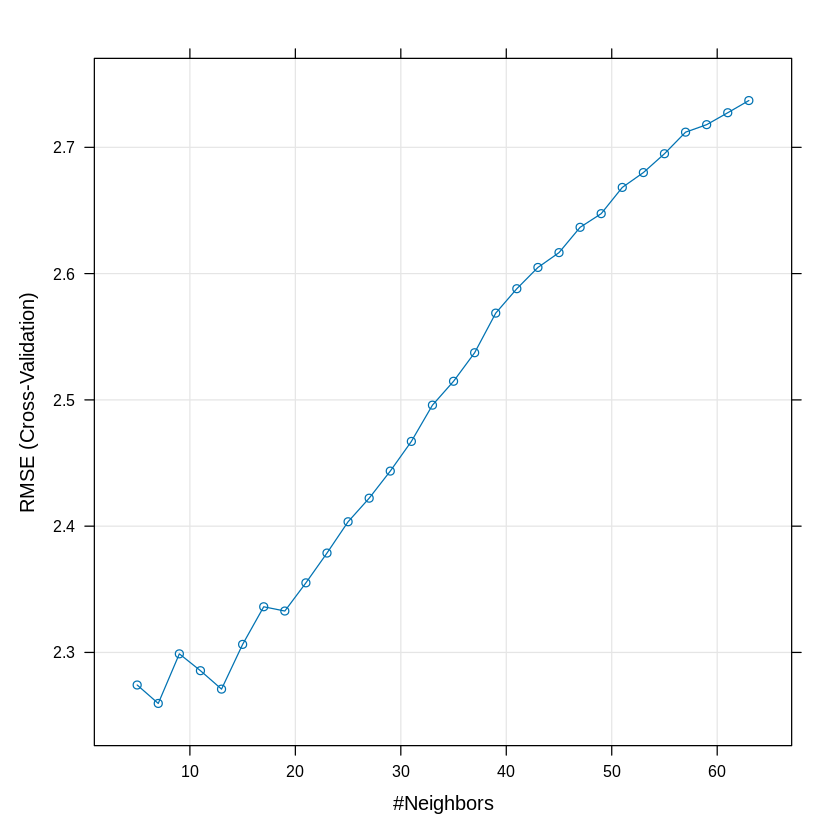

k,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,2.269762,0.7675848,1.782827,0.3107013,0.06963172,0.2517439


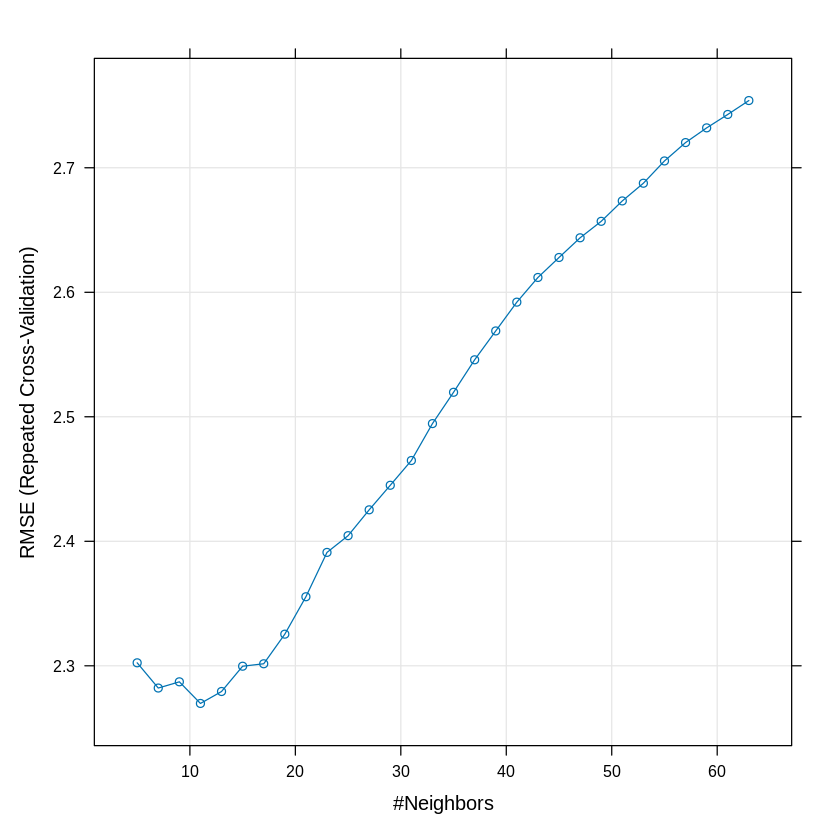

In [24]:
# Set options for the cross-validation routine with 10-folds
ctrl <- trainControl(method="cv", number = 10)

# Fit the model...
knnFit.value <- train(MeanF ~ .,
                data = dc.bg.data.wgs84.train, method = "knn", trControl = ctrl,
                preProcess = c("center","scale"), tuneLength = 30)

# Examine the output
knnFit.value
plot(knnFit.value)


# Try again using a different resampling method where
# 10-folds are repeated 3 times
ctrl <- trainControl(method="repeatedcv", repeats = 3)
knnFit.value <- train(MeanF ~ ., 
                data = dc.bg.data.wgs84.train, method = "knn", trControl = ctrl, 
                preProcess = c("center","scale"), tuneLength = 30)
knnFit.value
plot(knnFit.value)

get_best_result = function(caret_fit) {
  best = which(rownames(caret_fit$results) == rownames(caret_fit$bestTune))
  best_result = caret_fit$results[best, ]
  rownames(best_result) = NULL
  best_result
}

get_best_result(knnFit.value)

We can more or less tell at which value of K the overall accuracy peaks (i.e., RMSE is lowest) from the graphic shown above. However, we can also retrieve this value directly and use it to predict mean LST for the test set we created before. The latter portions of the code below are [taken from this post](http://zevross.com/blog/2017/09/19/predictive-modeling-and-machine-learning-in-r-with-the-caret-package) and may be a useful reference as we move forward. 

,k
,<int>
4,11


[1] 2.375875

[1] 2.375875

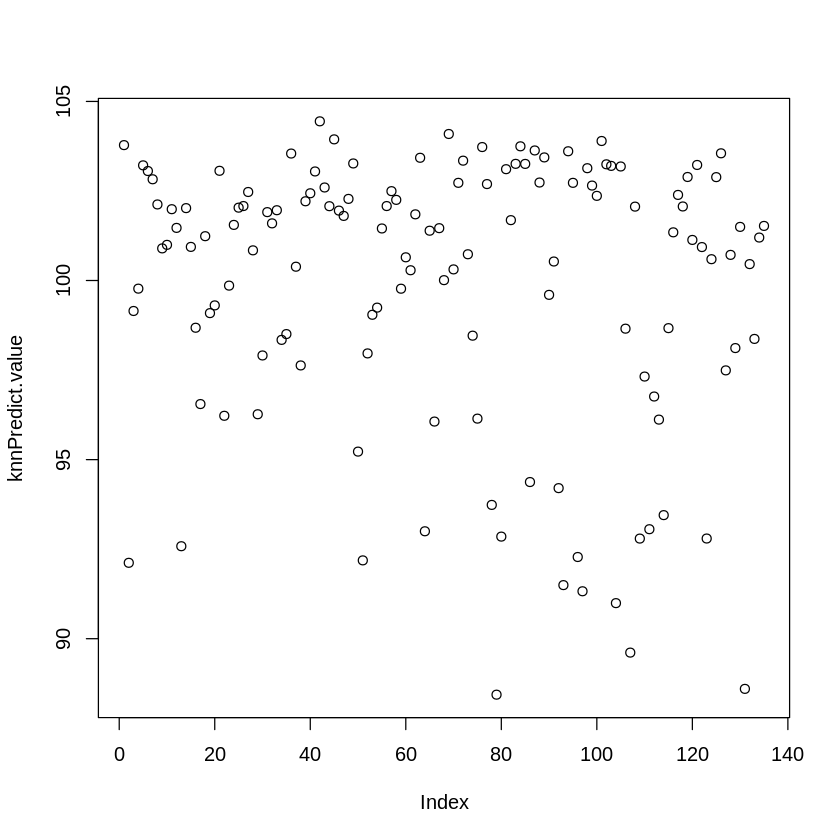

In [25]:
# Print the best tuning parameter k that maximizes model accuracy
knnFit.value$bestTune

# Now use the best fitting model to predict mean LST for the test set. 
knnPredict.value <- predict(knnFit.value, newdata = dc.bg.data.wgs84.test)
plot(knnPredict.value)

rmse(predicted = knnPredict.value, actual = dc.bg.data.wgs84.test$MeanF)


calc_rmse = function(actual, predicted) {
  sqrt(mean((actual - predicted) ^ 2))
}


calc_rmse(actual = dc.bg.data.wgs84.test$MeanF,
          predicted = predict(knnFit.value, dc.bg.data.wgs84.test))

In [26]:
# Compare to OLS and random forest models
lm.value <- train(MeanF ~., data = dc.bg.data.wgs84.train, method = "lm")
rf.value <- train(MeanF ~., data = dc.bg.data.wgs84.train, method = "rf")
knn.value <- train(MeanF ~ ., data = dc.bg.data.wgs84.train, method = "knn")

lm.value$finalModel
summary(lm.value$finalModel)$r.squared


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
  (Intercept)         TotPop             ai        area_mn       cohesion  
   -2.234e+01      3.326e-04      1.557e+00     -6.295e+01     -2.852e-01  
          lpi       division             pd          split          Water  
   -5.196e-02      1.077e+00      6.085e-04      7.219e-03     -1.999e-01  
Dev_OpenSpace      Grassland  
   -9.370e-02      8.139e-01  


[1] 0.8103535

In [27]:
# The caret package will bootstrap the data 25 times by default
lm.value$results$Rsquared

# Compare models
model_list <- list(lm = lm.value, rf = rf.value, knn = knn.value)
res <- resamples(model_list)
summary(res)

compare_models(lm.value, rf.value)
compare_models(rf.value, knn.value)

# Use stepwise approach to find best fitting OLS model...
tr <- trainControl(method = "repeatedcv", number = 10, repeats = 5)
step_model <- train(MeanF ~ ., data = dc.bg.data.wgs84.train, 
                    method = "lmStepAIC", trControl = tr, trace = FALSE)
step_model$results
step_model$finalModel

[1] 0.7793028


Call:
summary.resamples(object = res)

Models: lm, rf, knn 
Number of resamples: 25 

MAE 
        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
lm  1.518793 1.653511 1.719609 1.715236 1.791276 1.979615    0
rf  1.409313 1.524402 1.571925 1.597437 1.671929 1.781551    0
knn 1.623261 1.772724 1.826700 1.814467 1.869707 2.014098    0

RMSE 
        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
lm  1.911343 2.097375 2.187918 2.243498 2.267193 3.164376    0
rf  1.759327 2.005727 2.088359 2.106146 2.221114 2.378565    0
knn 2.044632 2.227463 2.296576 2.325165 2.470723 2.649040    0

Rsquared 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
lm  0.7353987 0.7572876 0.7695974 0.7793028 0.8034164 0.8397778    0
rf  0.6903723 0.7561080 0.7725390 0.7812497 0.8033135 0.8588811    0
knn 0.6623812 0.7416039 0.7624466 0.7558112 0.7795577 0.8190952    0



	One Sample t-test

data:  x
t = 2.7399, df = 24, p-value = 0.01141
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.03388677 0.24081601
sample estimates:
mean of x 
0.1373514 



	One Sample t-test

data:  x
t = -6.0522, df = 24, p-value = 2.997e-06
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2937069 -0.1443302
sample estimates:
 mean of x 
-0.2190185 


,parameter,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,2.124428,0.7979649,1.668635,0.4173263,0.06149833,0.2486808



Call:
lm(formula = .outcome ~ TotPop + ai + area_mn + lpi + pd + split + 
    Water + Dev_OpenSpace + Grassland, data = dat)

Coefficients:
  (Intercept)         TotPop             ai        area_mn            lpi  
   -4.811e+01      3.195e-04      1.543e+00     -6.349e+01     -6.220e-02  
           pd          split          Water  Dev_OpenSpace      Grassland  
    6.794e-04      7.942e-03     -2.019e-01     -9.640e-02      8.057e-01  


### Fitting Regression Tree Models 

The KNN approach is simplistic, but its results are often used as input (i.e., another independent variable) to more sophisticated models. Next, let's use the **rpart** package to fit **tree** models to our data. Take a few moments to review the help documentation for the `rpart` and the `rpart.object` functions, then proceed with the code chunk below. 

n= 315 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 315 6659.086000  99.72802  
   2) pd< 2590.704 67  849.904400  92.91203  
     4) pd< 1116.009 16   55.673050  88.20297 *
     5) pd>=1116.009 51  328.115300  94.38939  
      10) cohesion>=99.60707 14   41.757190  92.28987 *
      11) cohesion< 99.60707 37  201.296000  95.18380  
        22) Grassland< 0.1379151 30  115.557700  94.53075 *
        23) Grassland>=0.1379151 7   18.112690  97.98256 *
   3) pd>=2590.704 248 1855.596000 101.56940  
     6) cohesion>=98.01506 90  631.322400  99.44852  
      12) Water>=20.79596 3    2.463628  91.34554 *
      13) Water< 20.79596 87  425.091600  99.72793 *
     7) cohesion< 98.01506 158  588.819900 102.77760  
      14) area_mn>=0.01349867 56  244.035500 101.86070 *
      15) area_mn< 0.01349867 102  271.862500 103.28090 *

Call:
rpart(formula = MeanF ~ ., data = dc.bg.data.wgs84.train, method = "anova", 
    minsplit = 4, minbucket = 2)
  n= 315 

          CP nsplit rel error    xerror       xstd
1 0.59371294      0 1.0000000 1.0068881 0.09213192
2 0.09542656      1 0.4062871 0.4307214 0.04280041
3 0.06999701      2 0.3108605 0.3535738 0.03512248
4 0.03059987      3 0.2408635 0.2851512 0.02807262
5 0.01277384      4 0.2102636 0.2649286 0.02550535
6 0.01095074      5 0.1974898 0.2656734 0.02505968
7 0.01015539      6 0.1865390 0.2654787 0.02407782
8 0.01000000      7 0.1763837 0.2663303 0.02419130

Variable importance
      area_mn            pd      cohesion            ai      division 
           21            21            18            14            10 
        split           lpi Dev_OpenSpace         Water 
            9             2             2             1 

Node number 1: 315 observations,    complexity param=0.5937129
  mean=99.72802, MSE=21.13995 
  left son=2 (67 obs) right son=3 (248 obs

,var,n,wt,dev,yval,complexity,ncompete,nsurrogate
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,pd,315,315,6659.085684,99.72802,0.593712944,4,5
2,pd,67,67,849.904427,92.91203,0.069997006,4,5
4,<leaf>,16,16,55.673048,88.20297,0.010000000,0,0
5,cohesion,51,51,328.115319,94.38939,0.012773842,4,5
10,<leaf>,14,14,41.757186,92.28987,0.010000000,0,0
11,Grassland,37,37,201.296022,95.18380,0.010155389,4,1
22,<leaf>,30,30,115.557722,94.53075,0.003531824,0,0
23,<leaf>,7,7,18.112695,97.98256,0.010000000,0,0
3,cohesion,248,248,1855.595889,101.56943,0.095426563,4,5


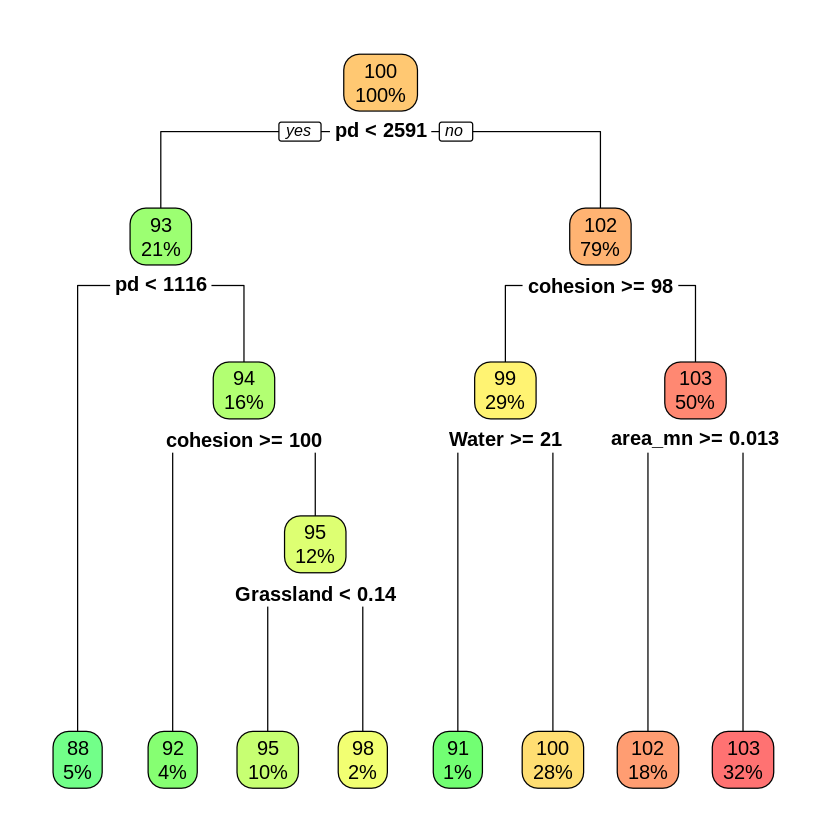

In [28]:
# Because our dependent variable is continuous, we set 
# the methods argument to "anova" for regression...
model.lst <- rpart(
  formula = MeanF ~ .,
  data    = dc.bg.data.wgs84.train,
  method  = "anova", 
  minsplit = 4, 
  minbucket = 2
)

# Examine the output in both text and visual format...
model.lst
rpart.plot(model.lst, box.palette = "GnYlRd")

# Retrieve more detailed info...
summary(model.lst)

# Display the frame attribute
model.lst$frame

In this simple model, we begin with 315 observations in the training set and there are five internal nodes and six terminal nodes or leaves. As we move down the tree, the plot communicates which independent variables were chosen for splits, the values of those independent variables that optimized the split criterion (e.g., [**Gini impurity**](https://blog.quantinsti.com/gini-index/)), the average value of the independent variable in question at each node, and the percentage of the observations that "flow" to each node. 

As shown above, typing the name of the **rpart object** displays model information that mirrors what we see in the tree plot, but in text form. Note how the depth of the indent reflects the structure of the (plotted) tree. These are the elements shown above: 
    + node: a unique number for the node in the tree
    + split: the equation used to branch at the node
    + n: number of observations that "flow" through that branch
    + deviance (for regression): the deviance associated with that branch 
    + yval: predicted value at the node
    + *: an asterisk next to a node indicates it is terminal

Applying the `summary` function to an **rpart object** displays more detailed information. As shown in the documentation for the `rpart.object` function, the frame attribute of an rpart object (i.e., **model.lst$frame**) is a "data frame with one row for each node in the tree." The **var** column lists variables used at each split, **n** is the number of observations reaching that node, **wt** is the sum of of case weights (1 by default) for observations reaching that node, **dev** is the deviance which is a goodness of fit statistic that equals the sum of squared residuals for linear models. The **yval** column is the fitted value of the dependent variable at the node, **complexity** is the complexity parameter at which this split will collapse, **ncompete** is the number of competitor splits recorded, and **nsurrogate** is the number of surrogate splits recorded. 

Surrogate variables are used when a value is missing and so a split cannot be completed with the main variable. A surrogate is a different variable that is chosen to approximate the first-choice variable in a split. 

We can retrieve the **cp** value for the model and set it to a value above the threshold for the second **area_mn** split to demonstrate its effects like this: `model.lst$control$cp`

In [ ]:
# Prune the model...
model.pruned <- prune(model.lst, cp = 0.02)
model.pruned$frame
rpart.plot(model.pruned, box.palette = "GnYlRd")


# We could also set this parameter explicitly and rerun the model: 
temp <- rpart.control(cp = 0.02)
model.lst.2 <- rpart(
  formula = MeanF ~ .,
  data    = dc.bg.data.wgs84.train,
  method  = "anova",
  control = temp
)

model.lst.2$frame
rpart.plot(model.lst.2, box.palette = "GnYlRd")

According to the `rpart.object` documentation, the **cp table** is *"a matrix of information on the optimal prunings based on a complexity parameter"*. Behind the scenes `rpart` is automatically applying an array of cost complexity values to prune the tree. The **CP** column is the value of this parameter that would grow the tree to this size. The **nsplit** column is the number of nodes at that size, **rel error** is  is the error for predictions of the data that were used to estimate the model, while **xerror** is the cross-validation error generated by the `rpart` built-in cross validation routine and **xstd** gives us a sense of its variability over the default 10 iterations (see `plotcp`). Also note that (1 - relative error) is roughly equal to the variance explained by the model.

The **CP** values control the size of the tree and the greater the **CP** value, the fewer the number of splits in the tree. The optimal size of the tree is generally the row in the **CP table** that minimizes all error with the fewest branches. 

In the plot below, the dotted line refers to a recommendation from Breiman et al. (1984) to use the smallest tree within 1 standard deviation of the minimum cross validation error. You can think about the complexity parameter as the amount by which splitting that node improved the relative error. 

In [ ]:
model.lst$cptable
plotcp(model.lst)

model.lst$splits

The splits attribute consists of a row label which is the name of the split variable, and the rest of the columns are **count**, the number of observations sent left or right by the split (for competitor splits this is the number that would have been sent left or right had this split been used, for surrogate splits it is the number missing the primary split variable which were decided using this surrogate), **ncat** which is the number of categories or levels for the variable (+/-1 for a continuous variable), **improve** which is the improvement in deviance given by this split, or, for surrogates, the concordance of the surrogate with the primary, and **index**, the numeric split point. The last column **adj** gives the adjusted concordance for surrogate splits. For a continuous variable, the sign of **ncat** determines whether the subset x < cutpoint or x > cutpoint is sent to the left. 

A case weight is a nonnegative numeric variable that indicates the importance of each case. There are three types of case weights: frequencies, sampling weights, and variance weights.

In [ ]:
#Use Regression Tree for Prediction

model.lst.pred <-  predict(model.lst, newdata = dc.bg.data.wgs84.test)

caret::RMSE(pred = model.lst.pred, obs = dc.bg.data.wgs84.test$MeanF)

dc.test.bgs$rtpred <- model.lst.pred


In [ ]:
# Now create a couple of plots to compare the predicted 
# values to the observed values (i.e., from the satellite imagery)
fitted <- ggplot() +
  geom_sf(data = dc.test.bgs, aes(fill = rtpred)) + theme_void() + 
  scale_fill_gradient(low = "yellow", high = "red") + 
  labs(title = "Predicted LST") + 
  theme(plot.title = element_text(hjust = 0.5))

fitted

observed <- ggplot() +
  geom_sf(data = dc.test.bgs, aes(fill = MeanF)) + theme_void() + 
  scale_fill_gradient(low = "yellow", high = "red") + 
  labs(title = "Satellite LST", fill = "Land Surface Temperature °F") +
  theme(plot.title = element_text(hjust = 0.5))

observed

In [ ]:
# Now map the residuals...
dc.test.bgs$rtresid <- dc.test.bgs$MeanF - dc.test.bgs$rtpred

the.diff <- ggplot() +
  geom_sf(data = dc.test.bgs, aes(fill = rtresid)) + theme_void() + 
  scale_fill_gradient(low = "green", high = "red") + 
  labs(title = "Difference in Satellite and Predicted LST", fill = "°F") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.margin = unit(c(1, 1, 2, 1), unit = "cm"))

the.diff

Based on the results from the above code chunk, this model does not fit the validation set **super** well. We could modify the predictors (independent variables) we have included (see the "Fit-Initial-Regression-Tree" chunk) to try and improve our predictive capacity. Alternatively, we could pursue one a strategy known as[bootstrap aggregating](https://en.wikipedia.org/wiki/Bootstrap_aggregating) or "bagging". This technique involves sampling with replacement and fitting the model each time as a means of improving the stability and predictive power of our tree-based model. 

In [ ]:
# Specify the standard 10-fold cross validation
ctrl <- trainControl(method = "cv",  number = 10) 

# Fit the bagged model but setting the method argument to 
# treebagged as shown below...
model.bagged <- train(
  MeanF ~ .,
  data    = dc.bg.data.wgs84.train,
  method = "treebag",
  trControl = ctrl,
  importance = TRUE,
  minsplit = 4, minbucket = 2
)

# Assess the results
model.bagged

# plot most important variables
plot(varImp(model.bagged), 2)  

# Make predictions
pred <- predict(model.bagged$finalModel, dc.bg.data.wgs84.test)
caret::RMSE(pred = pred, obs = dc.bg.data.wgs84.test$MeanF)

As we can see, the "bagging" technique allowed us to identify a model with greater predictive capacity. There are several resources available that go into greater detail with bootstrap aggregation including [this post from R Bloggers](https://www.r-bloggers.com/2017/06/machine-learning-explained-bagging) and [this tutorial from Brad Boehmke](https://bradleyboehmke.github.io/HOML/bagging.html).  

We can also explore how well this model we fitted for Washington DC performs in other cities. 